In [1]:
from time import time
import keras
import os
import sys
sys.path.append('../')
from utils.utils import smooth_labels, CLRScheduler, LinearDecayScheduler, WarmUpCosineDecayScheduler
from utils.codification_cnn import CNNLayer, NNLayer, ChromosomeCNN, FitnessCNN, FitnessCNNParallel

from utils.codification_skipc import FitnessSkip, Connections, ChromosomeSkip
from utils.datamanager import DataManager
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
%matplotlib inline


def get_chromosome_from_file(filename):
    cnn_layers = []
    nn_layers = []
    connections = []
    with open(filename, 'r') as f:
        for line in f:
            params = line.split('|')            
            if 'CNN' == params[0]:
                filters = int(params[1].split(':')[1])
                kernel = literal_eval(params[2].split(':')[1])
                activation = params[3].split(':')[1]
                dropout = float(params[4].split(':')[1])
                maxpool = bool(int(params[5].split(':')[1]))
                cnn_layers.append(CNNLayer(filters, kernel, activation, dropout, maxpool))
            elif 'NN' == params[0]:
                units = int(params[1].split(':')[1])
                activation = params[2].split(':')[1]
                dropout = float(params[3].split(':')[1])
                nn_layers.append(NNLayer(units, activation, dropout))
            else:
                try:
                    local_connections = [int(el) for el in params[0].split("\n")[0]]
                    if len(local_connections) > 0:
                        connections.append(local_connections)
                except ValueError:
                    pass
        max_len = np.max([len(e) for e in connections])
        matrix = np.array([el + [0] * (max_len - len(el)) for el in connections])
        connections = Connections(matrix)
    return ChromosomeSkip(cnn_layers, nn_layers, connections)


def show_result(history, metric='acc'):
        color = np.array([[31, 119, 180], [255, 127, 14]]) / 255.
        try:
            epochs = np.linspace(0, len(history.history['acc']) - 1, len(history.history['acc']))
            argmax_val = np.argmax(history.history['val_%s' % metric])
            plt.plot(epochs, history.history['val_%s' % metric], label='validation', color=color[0], alpha=0.5)
            plt.plot(epochs, median_filter(history.history['val_%s' % metric]), color=color[0])
            plt.scatter(epochs[argmax_val], history.history['val_%s' % metric][argmax_val],
            label='max val_%s %0.4f' % (metric, history.history['val_%s' % metric][argmax_val]), c='r')
        except KeyError:
            pass
        plt.plot(epochs, history.history[metric], label='train', color=color[1], alpha=0.5)
        plt.plot(epochs, median_filter(history.history[metric]), color=color[1])


        plt.legend()
        plt.xlabel('Epochs')
        #plt.xticks([20, 40, 60, 80, 120, 160, 180])
        plt.grid()
        plt.ylabel(metric)
        plt.show()
        
def median_filter(v, size=5):
    stride = (size - 1) // 2
    filtered_v = []
    for i in range(len(v)):
        if i < stride or i + stride == len(v):
            filtered_v.append(v[i])
        else:
            filtered_v.append(np.mean(v[i-stride:i + stride + 1]))
    return filtered_v


data_folder = '/home/daniel/datasets/MNIST_variations'
command = 'python ./train_gen.py'
verbose = 1
experiments_folder = '../super_conv'
gpus = 1

Using TensorFlow backend.


In [206]:
# dataset params:
data_folder = data_folder
smooth = 0.1
classes = []

dataset = 'MRDBI'
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
(x_train, y_train), (x_test, y_test), (x_val, y_val) = dm.load_data()


if smooth > 0:
    y_train = smooth_labels(y_train, smooth)

KeyboardInterrupt: 

In [27]:
# Fitness params
epochs = 10
batch_size = 128
base_lr = 0.001
smooth = 0.1

In [207]:
keras.backend.clear_session()

f = FitnessSkip()
f.input_shape = (28, 28, 1)
f.num_clases = 10
f.verb = 0

c = get_chromosome_from_file('./models/%s' % dataset)
model = f.decode(c)

In [38]:
# Create the Learning rate scheduler.
total_steps = int(epochs * y_train.shape[0] / batch_size)

clr = CLRScheduler(min_lr=0.00003,
                   max_lr=0.03,
                   total_steps=total_steps,
                   cycles=2)

llr = LinearDecayScheduler(learning_rate_base=base_lr,
                           total_steps=total_steps,
                           warmup_learning_rate=0.0,
                           warmup_steps=0,
                           hold_base_rate_steps=0, verbose=1)


wlr = WarmUpCosineDecayScheduler(learning_rate_base=base_lr,
                                 total_steps=total_steps,
                                 warmup_learning_rate=0.0,
                                 warmup_steps=0,
                                 hold_base_rate_steps=0)


callbacks = [clr]

In [39]:
ti = time()

h = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),
          shuffle=True,
          callbacks=callbacks,
          verbose=1)
    
# score trained model
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print("Elapsed time: %0.2f" % ((time() - ti) / 60.))

Train on 9600 samples, validate on 2400 samples
Epoch 1/10
9600/9600 [==============================] - 30s 3ms/step - loss: 2.5331 - acc: 0.2485 - val_loss: 1.6635 - val_acc: 0.4304
Epoch 2/10
9600/9600 [==============================] - 28s 3ms/step - loss: 1.5118 - acc: 0.5710 - val_loss: 1.0840 - val_acc: 0.6421
Epoch 3/10
9600/9600 [==============================] - 28s 3ms/step - loss: 1.1754 - acc: 0.7311 - val_loss: 0.7964 - val_acc: 0.7554
Epoch 4/10
9600/9600 [==============================] - 28s 3ms/step - loss: 0.9658 - acc: 0.8289 - val_loss: 0.5591 - val_acc: 0.8467
Epoch 5/10
9600/9600 [==============================] - 28s 3ms/step - loss: 0.8328 - acc: 0.8927 - val_loss: 0.5238 - val_acc: 0.8667
Epoch 6/10
9600/9600 [==============================] - 28s 3ms/step - loss: 0.7925 - acc: 0.9116 - val_loss: 0.4818 - val_acc: 0.8608
Epoch 7/10
9600/9600 [==============================] - 28s 3ms/step - loss: 0.8463 - acc: 0.8882 - val_loss: 0.7154 - val_acc: 0.7892
Epoch 8

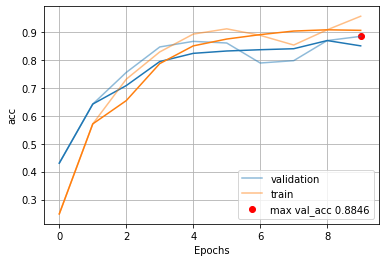

0.007780000000000009

In [40]:
show_result(h)

plt.plot(callbacks[0].learning_rates)
plt.grid()
plt.show()

plt.plot(callbacks[0].accs, label='acc')
plt.legend()
plt.grid()
plt.show()
plt.plot(callbacks[0].losses, label='loss')
plt.legend()
plt.grid()
plt.show()


In [57]:
cycles = [1]
epochs = 18
total_steps = int(epochs * y_train.shape[0] / batch_size)
  
f = FitnessSkip()
f.input_shape = (28, 28, 1)
f.num_clases = 10
f.verb = 0

for c in cycles:
    print("%d Number of cycles" % c)
    keras.backend.clear_session()
    model = f.decode(get_chromosome_from_file('./models/%s' % dataset))
    callbacks = [CLRScheduler(min_lr=0.00003,
                              max_lr=0.03,
                              total_steps=total_steps,
                              cycles=c)]

    h = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),
          shuffle=True,
          callbacks=callbacks,
          verbose=1)

1 Number of cycles
Train on 9600 samples, validate on 2400 samples
Epoch 1/18
9600/9600 [==============================] - 29s 3ms/step - loss: 2.5956 - acc: 0.2328 - val_loss: 1.7503 - val_acc: 0.4367
Epoch 2/18
9600/9600 [==============================] - 28s 3ms/step - loss: 1.6478 - acc: 0.5189 - val_loss: 1.0914 - val_acc: 0.6262
Epoch 3/18
9600/9600 [==============================] - 28s 3ms/step - loss: 1.2786 - acc: 0.6811 - val_loss: 0.7356 - val_acc: 0.7692
Epoch 4/18
9600/9600 [==============================] - 28s 3ms/step - loss: 1.1119 - acc: 0.7643 - val_loss: 0.7241 - val_acc: 0.7775
Epoch 5/18
9600/9600 [==============================] - 28s 3ms/step - loss: 1.0164 - acc: 0.8113 - val_loss: 0.7411 - val_acc: 0.7738
Epoch 6/18
9600/9600 [==============================] - 28s 3ms/step - loss: 0.9552 - acc: 0.8319 - val_loss: 0.8829 - val_acc: 0.7317
Epoch 7/18
9600/9600 [==============================] - 28s 3ms/step - loss: 0.8887 - acc: 0.8662 - val_loss: 0.8624 - val_

In [56]:
max_lrts = [0.03/(np.sqrt(10)**i) for i in range(3)]
epochs = 6
total_steps = int(epochs * y_train.shape[0] / batch_size)
  
f = FitnessSkip()
f.input_shape = (28, 28, 1)
f.num_clases = 10
f.verb = 0

keras.backend.clear_session()
model = f.decode(get_chromosome_from_file('./models/%s' % dataset))
   
callbacks = [CLRScheduler(min_lr=0.00003,
                          max_lr=max_lr,
                          total_steps=total_steps * len(max_lrts),
                          cycles=len(max_lrts))]

for i, max_lr in enumerate(max_lrts):
    print("Maximum learning rate: %0.5f" % max_lr)
    callbacks[0].max_lr = max_lr

    h = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs * (i + 1),
          validation_data=(x_val, y_val),
          shuffle=True,
          callbacks=callbacks,
          initial_epoch=epochs * i,
          verbose=1)

Maximum learning rate: 0.01500
Train on 9600 samples, validate on 2400 samples
Epoch 1/6
9600/9600 [==============================] - 29s 3ms/step - loss: 2.5500 - acc: 0.2314 - val_loss: 1.7356 - val_acc: 0.4463
Epoch 2/6
9600/9600 [==============================] - 28s 3ms/step - loss: 1.5963 - acc: 0.5342 - val_loss: 1.0540 - val_acc: 0.6554
Epoch 3/6
9600/9600 [==============================] - 28s 3ms/step - loss: 1.2399 - acc: 0.7080 - val_loss: 0.8232 - val_acc: 0.7504
Epoch 4/6
9600/9600 [==============================] - 28s 3ms/step - loss: 1.0565 - acc: 0.7894 - val_loss: 0.5963 - val_acc: 0.8171
Epoch 5/6
9600/9600 [==============================] - 28s 3ms/step - loss: 0.9061 - acc: 0.8606 - val_loss: 0.4957 - val_acc: 0.8588
Epoch 6/6
9600/9600 [==============================] - 28s 3ms/step - loss: 0.8020 - acc: 0.9082 - val_loss: 0.4913 - val_acc: 0.8725
Maximum learning rate: 0.01500
Train on 9600 samples, validate on 2400 samples
Epoch 7/12
9600/9600 [================

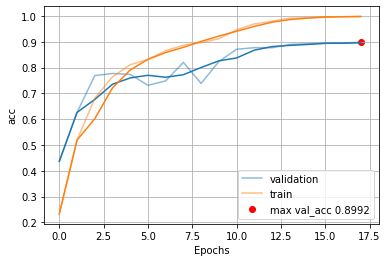

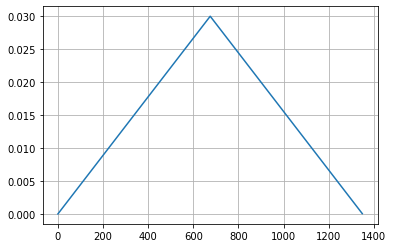

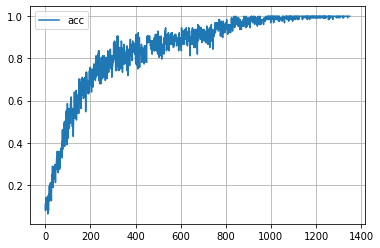

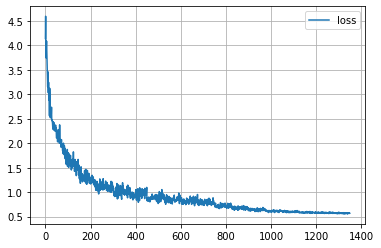

In [58]:
show_result(h)

plt.plot(callbacks[0].learning_rates)
plt.grid()
plt.show()

plt.plot(callbacks[0].accs, label='acc')
plt.legend()
plt.grid()
plt.show()
plt.plot(callbacks[0].losses, label='loss')
plt.legend()
plt.grid()
plt.show()

In [69]:
cycles = [1]
epochs = 18
w_epochs = epochs // 3
total_steps = int(epochs * y_train.shape[0] / batch_size)
w_steps = int(w_epochs * y_train.shape[0] / batch_size)
  
f = FitnessSkip()
f.input_shape = (28, 28, 1)
f.num_clases = 10
f.verb = 0

for c in cycles:
    print("%d Number of cycles" % c)
    keras.backend.clear_session()
    model = f.decode(get_chromosome_from_file('./models/%s' % dataset))
    callbacks = [LinearDecayScheduler(learning_rate_base=0.03,
                           total_steps=total_steps,
                           warmup_learning_rate=0.00003,
                           warmup_steps=w_steps,
                           hold_base_rate_steps=0, verbose=0)]

    h = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),
          shuffle=True,
          callbacks=callbacks,
          verbose=1)

1 Number of cycles
Train on 9600 samples, validate on 2400 samples
Epoch 1/18
9600/9600 [==============================] - 29s 3ms/step - loss: 2.5149 - acc: 0.2407 - val_loss: 1.5809 - val_acc: 0.4842
Epoch 2/18
9600/9600 [==============================] - 28s 3ms/step - loss: 1.5424 - acc: 0.5580 - val_loss: 1.0935 - val_acc: 0.6442
Epoch 3/18
9600/9600 [==============================] - 28s 3ms/step - loss: 1.2273 - acc: 0.7074 - val_loss: 1.1699 - val_acc: 0.6887
Epoch 4/18
9600/9600 [==============================] - 28s 3ms/step - loss: 1.0351 - acc: 0.7976 - val_loss: 0.9359 - val_acc: 0.7158
Epoch 5/18
9600/9600 [==============================] - 28s 3ms/step - loss: 0.9213 - acc: 0.8542 - val_loss: 0.5740 - val_acc: 0.8213
Epoch 6/18
9600/9600 [==============================] - 28s 3ms/step - loss: 0.8612 - acc: 0.8774 - val_loss: 0.5406 - val_acc: 0.8367
Epoch 7/18
9600/9600 [==============================] - 28s 3ms/step - loss: 0.8005 - acc: 0.9101 - val_loss: 0.4860 - val_

In [70]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

50000/50000 [==============================] - 44s 886us/step
Test loss: 0.42343714359760287
Test accuracy: 0.89146


In [189]:
import keras.backend as K
import keras
import math



class LrTestFinderWithLinearDecaySchedule(keras.callbacks.Callback):
    """Linear decay with warmup learning rate scheduler
        """

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        super(LrTestFinderWithLinearDecaySchedule, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []
        self.max_lr = 0
        self.losses = []
        self.accs = []
        self.best_loss = 1e9
        self.lr_step = (self.learning_rate_base / self.warmup_learning_rate) ** (1 / self.warmup_steps)
        #self.lr_step = (self.learning_rate_base - self.warmup_learning_rate) * (1 / self.warmup_steps)
        self.decreasing = False
        self.steps_without_improve = 0
        
    def on_train_begin(self, logs=None):
        K.set_value(self.model.optimizer.lr, self.warmup_learning_rate)
        self.decreasing = False
        
        
    def on_batch_end(self, batch, logs=None):
        lr = K.get_value(self.model.optimizer.lr)
        loss = logs['loss']
        acc = logs['acc']
        self.accs.append(acc)
        self.losses.append(loss)
        self.learning_rates.append(lr)
        self.global_step = self.global_step + 1         
        if not self.decreasing:
            # Check whether the loss got too large or NaN
            if self.global_step>self.warmup_steps*0.33:
                n = 10
                last_accs = np.mean(self.accs[-2*n:-n])
                acc = np.mean(self.accs[-n::])
                cond = acc < last_accs
                if cond or math.isnan(loss) or self.global_step>self.warmup_steps:
                    self.decreasing = True
                    self.max_lr = lr / 5
                    self.warmup_steps = self.global_step
                    print("\nLearning rate fund %0.5f" % self.max_lr)
                    return

            if loss < self.best_loss:
                self.best_loss = loss

            # Increase the learning rate for the next batch
            lr *= self.lr_step
            K.set_value(self.model.optimizer.lr, lr)

    def on_batch_begin(self, batch, logs=None):
        if self.decreasing:
            lr = linear_decay_with_warmup(global_step=self.global_step,
                                          learning_rate_base=self.max_lr,
                                          total_steps=self.total_steps,
                                          warmup_learning_rate=0,
                                          warmup_steps=self.warmup_steps,
                                          hold_base_rate_steps=self.hold_base_rate_steps)
            K.set_value(self.model.optimizer.lr, lr)
            if self.verbose > 0:
                print('\nBatch %05d: setting learning '
                      'rate to %s.' % (self.global_step + 1, lr))
        
                       
def linear_decay_with_warmup(global_step, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps,
                             hold_base_rate_steps):
    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = learning_rate_base * (1 - (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps))

    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)

In [190]:
epochs = 12
w_epochs = epochs // 3
total_steps = int(epochs * y_train.shape[0] / batch_size)
w_steps = int(w_epochs * y_train.shape[0] / batch_size)
  
f = FitnessSkip()
f.input_shape = (28, 28, 1)
f.num_clases = 10
f.verb = 0

keras.backend.clear_session()
model = f.decode(get_chromosome_from_file('./models/%s' % dataset))
callbacks = [LrTestFinderWithLinearDecaySchedule(learning_rate_base=1.0,
                                                 total_steps=total_steps,
                                                 warmup_learning_rate=0.00003,
                                                 warmup_steps=w_steps)]

h = model.fit(x_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(x_val, y_val),
      shuffle=True,
      callbacks=callbacks,
      verbose=1)

Train on 9600 samples, validate on 2400 samples
Epoch 1/12
9600/9600 [==============================] - 29s 3ms/step - loss: 3.0871 - acc: 0.1422 - val_loss: 2.2251 - val_acc: 0.2492
Epoch 2/12
9600/9600 [==============================] - 27s 3ms/step - loss: 2.2143 - acc: 0.3016 - val_loss: 2.0938 - val_acc: 0.4771
Epoch 3/12
9600/9600 [==============================] - 28s 3ms/step - loss: 1.6334 - acc: 0.5344 - val_loss: 4.7410 - val_acc: 0.5163
Epoch 4/12
4480/9600 [=============>................] - ETA: 14s - loss: 1.4790 - acc: 0.6040
Learning rate fund 0.04818
9600/9600 [==============================] - 28s 3ms/step - loss: 1.4901 - acc: 0.6293 - val_loss: 1.4581 - val_acc: 0.6758
Epoch 5/12
9600/9600 [==============================] - 28s 3ms/step - loss: 0.9964 - acc: 0.8177 - val_loss: 0.5777 - val_acc: 0.8262
Epoch 6/12
9600/9600 [==============================] - 28s 3ms/step - loss: 0.8955 - acc: 0.8614 - val_loss: 0.5458 - val_acc: 0.8488
Epoch 7/12
9600/9600 [==========

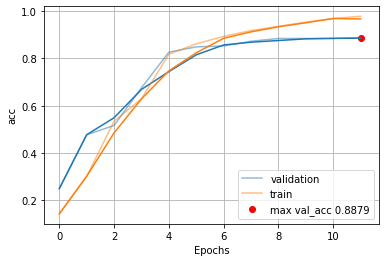

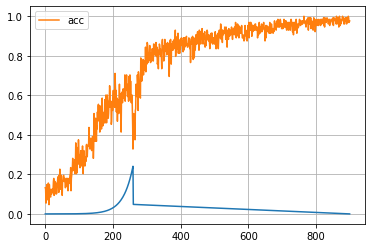

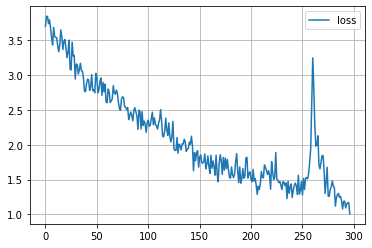

In [191]:
show_result(h)

plt.plot(callbacks[0].learning_rates)
#plt.grid()
#plt.show()

plt.plot(median_filter(callbacks[0].accs, size=1), label='acc')
plt.legend()
plt.grid()
plt.show()
plt.plot(callbacks[0].losses[0:int(0.33*len(callbacks[0].losses))], label='loss')
plt.legend()
plt.grid()

plt.show()

In [200]:
epochs = 25
w_epochs = epochs // 2
total_steps = int(epochs * y_train.shape[0] / batch_size)
w_steps = int(w_epochs * y_train.shape[0] / batch_size)
  
f = FitnessSkip()
f.input_shape = (28, 28, 1)
f.num_clases = 10
f.verb = 0

keras.backend.clear_session()
model = f.decode(get_chromosome_from_file('./models/%s' % dataset))
callbacks = [LinearDecayScheduler(learning_rate_base=0.03,
                       total_steps=total_steps,
                       warmup_learning_rate=0.00003,
                       warmup_steps=w_steps,
                       hold_base_rate_steps=0, verbose=0)]

h = model.fit(x_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(x_val, y_val),
      shuffle=True,
      callbacks=callbacks,
      verbose=1)

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 9600 samples, validate on 2400 samples
Epoch 1/25
9600/9600 [==============================] - 30s 3ms/step - loss: 2.6805 - acc: 0.2138 - val_loss: 2.1726 - val_acc: 0.3662
Epoch 2/25
9600/9600 [==============================] - 28s 3ms/step - loss: 1.7408 - acc: 0.4765 - val_loss: 1.1355 - val_acc: 0.6050
Epoch 3/25
9600/9600 [==============================] - 28s 3ms/step - loss: 1.3224 - acc: 0.6630 - val_loss: 0.8053 - val_acc: 0.7396
Epoch 4/25
9600/9600 [==============================] - 28s 3ms/step - loss: 1.1227 - acc: 0.7579 - val_loss: 0.6932 - val_acc: 0.7783
Epoch 5/25
9600/9600 [==============================] - 28s 3ms/step - loss: 1.0376 - acc: 0.7980 - val_loss: 0.6343 - val_acc: 0.8037
Epoch 6/25
9600/9600 [==============================] - 28s 3ms/step - loss: 0.9654 - acc: 0.8356 - val_loss: 0.5776 - val_acc: 0.8192
Epoch 7/25
9600/9600 [==============================] - 28s 3ms/step - loss: 0.9117 - acc: 0.8608 - val_loss: 0.5629 - val_acc: 0.8321
Epoch 8

10.507999999999996


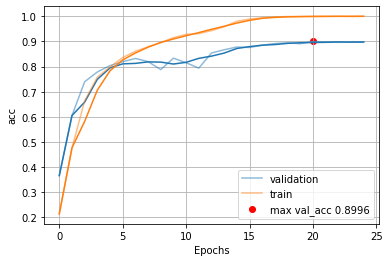

AttributeError: 'LinearDecayScheduler' object has no attribute 'accs'

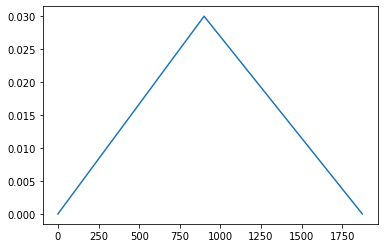

In [201]:
print(100-89.492)
show_result(h)

plt.plot(callbacks[0].learning_rates)
#plt.grid()
#plt.show()

plt.plot(median_filter(callbacks[0].accs, size=1), label='acc')
plt.legend()
plt.grid()
plt.show()
plt.plot(callbacks[0].losses, label='loss')
plt.legend()
plt.grid()

plt.show()

### Evaluating al datasets models with super convergence

In [3]:
# dataset params:
data_folder = data_folder
smooth = 0.1
classes = []
datasets = ['MRD', 'MBI', 'MRB', 'MB', 'MRDBI']
batch_size = 128
epochs = 25
w_epochs = epochs // 2

for dataset in datasets:
    print("Training in dataset %s" % dataset)
    dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
    (x_train, y_train), (x_test, y_test), (x_val, y_val) = dm.load_data()
    total_steps = int(epochs * y_train.shape[0] / batch_size)
    w_steps = int(w_epochs * y_train.shape[0] / batch_size)
    if smooth > 0:
        y_train = smooth_labels(y_train, smooth)
    keras.backend.clear_session()
    f = FitnessSkip()
    f.input_shape = (28, 28, 1)
    f.num_clases = 10
    f.verb = 0
    c = get_chromosome_from_file('./models/%s' % dataset)
    model = f.decode(c)
    callbacks = [LinearDecayScheduler(learning_rate_base=0.03,
                           total_steps=total_steps,
                           warmup_learning_rate=0.00003,
                           warmup_steps=w_steps,
                           hold_base_rate_steps=0, verbose=0)]

    h = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),
          shuffle=True,
          callbacks=callbacks,
          verbose=1)
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

Training in dataset MRD
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples
Train on 9600 samples, validate on 2400 samples
Epoch 1/25
9600/9600 [==============================] - 9s 900us/step - loss: 1.8877 - acc: 0.4773 - val_loss: 1.8597 - val_acc: 0.5988
Epoch 2/25
9600/9600 [==============================] - 8s 786us/step - loss: 1.1011 - acc: 0.7749 - val_loss: 1.2883 - val_acc: 0.6988
Epoch 3/25
9600/9600 [==============================] - 8s 786us/step - loss: 0.8993 - acc: 0.8641 - val_loss: 0.7269 - val_acc: 0.8000
Epoch 4/25
9600/9600 [==============================] - 8s 787us/step - loss: 0.8015 - acc: 0.9057 - val_loss: 0.5622 - val_acc: 0.8338
Epoch 5/25
9600/9600 [==============================] - 8s 788us/step - loss: 0.7879 - acc: 0.9103 - val_loss: 0.3551 - val_acc: 0.8979
Epoch 6/25
9600/9600 [==============================] - 8s 788us/step - loss: 0.7502 - acc: 0.9253 - val_loss: 0.2712 - val_acc: 0.9204
Epoch 7/25


Epoch 6/25
9600/9600 [==============================] - 15s 2ms/step - loss: 0.6086 - acc: 0.9729 - val_loss: 0.1580 - val_acc: 0.9721
Epoch 7/25
9600/9600 [==============================] - 15s 2ms/step - loss: 0.5897 - acc: 0.9803 - val_loss: 0.1689 - val_acc: 0.9700
Epoch 8/25
9600/9600 [==============================] - 15s 2ms/step - loss: 0.5690 - acc: 0.9854 - val_loss: 0.1756 - val_acc: 0.9604
Epoch 9/25
9600/9600 [==============================] - 15s 2ms/step - loss: 0.5644 - acc: 0.9862 - val_loss: 0.1716 - val_acc: 0.9675
Epoch 10/25
9600/9600 [==============================] - 15s 2ms/step - loss: 0.5592 - acc: 0.9871 - val_loss: 0.1504 - val_acc: 0.9729
Epoch 11/25
9600/9600 [==============================] - 15s 2ms/step - loss: 0.5528 - acc: 0.9905 - val_loss: 0.1479 - val_acc: 0.9717
Epoch 12/25
9600/9600 [==============================] - 15s 2ms/step - loss: 0.5441 - acc: 0.9925 - val_loss: 0.1771 - val_acc: 0.9654
Epoch 13/25
9600/9600 [=============================

9600/9600 [==============================] - 34s 4ms/step - loss: 0.7533 - acc: 0.9297 - val_loss: 0.6051 - val_acc: 0.8408
Epoch 13/25
9600/9600 [==============================] - 34s 3ms/step - loss: 0.7243 - acc: 0.9445 - val_loss: 0.6001 - val_acc: 0.8458
Epoch 14/25
9600/9600 [==============================] - 34s 3ms/step - loss: 0.6795 - acc: 0.9672 - val_loss: 0.4419 - val_acc: 0.8750
Epoch 15/25
9600/9600 [==============================] - 34s 4ms/step - loss: 0.6461 - acc: 0.9809 - val_loss: 0.4312 - val_acc: 0.8817
Epoch 16/25
9600/9600 [==============================] - 34s 3ms/step - loss: 0.6248 - acc: 0.9849 - val_loss: 0.4805 - val_acc: 0.8762
Epoch 17/25
9600/9600 [==============================] - 34s 3ms/step - loss: 0.6054 - acc: 0.9923 - val_loss: 0.4488 - val_acc: 0.8804
Epoch 18/25
9600/9600 [==============================] - 34s 3ms/step - loss: 0.5917 - acc: 0.9960 - val_loss: 0.4122 - val_acc: 0.8883
Epoch 19/25
9600/9600 [==============================] - 34s

In [5]:
data_folder = data_folder
smooth = 0.1
classes = []
datasets = ['MRD', 'MBI', 'MRB', 'MB', 'MRDBI']
batch_size = 128
epochs = 75
w_epochs = epochs // 2

for dataset in datasets:
    print("Training in dataset %s" % dataset)
    dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
    (x_train, y_train), (x_test, y_test), (x_val, y_val) = dm.load_data()
    total_steps = int(epochs * y_train.shape[0] / batch_size)
    w_steps = int(w_epochs * y_train.shape[0] / batch_size)
    if smooth > 0:
        y_train = smooth_labels(y_train, smooth)
    keras.backend.clear_session()
    f = FitnessSkip()
    f.input_shape = (28, 28, 1)
    f.num_clases = 10
    f.verb = 0
    c = get_chromosome_from_file('./models/%s' % dataset)
    model = f.decode(c)
    callbacks = [LinearDecayScheduler(learning_rate_base=0.03,
                           total_steps=total_steps,
                           warmup_learning_rate=0.00003,
                           warmup_steps=w_steps,
                           hold_base_rate_steps=0, verbose=0)]

    h = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),
          shuffle=True,
          callbacks=callbacks,
          verbose=1)
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

Training in dataset MRD
(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples
Train on 9600 samples, validate on 2400 samples
Epoch 1/75
9600/9600 [==============================] - 9s 899us/step - loss: 2.1265 - acc: 0.3965 - val_loss: 2.0083 - val_acc: 0.5096
Epoch 2/75
9600/9600 [==============================] - 8s 789us/step - loss: 1.2522 - acc: 0.7052 - val_loss: 1.1838 - val_acc: 0.7075
Epoch 3/75
9600/9600 [==============================] - 8s 790us/step - loss: 0.9722 - acc: 0.8322 - val_loss: 0.5559 - val_acc: 0.8342
Epoch 4/75
9600/9600 [==============================] - 8s 788us/step - loss: 0.8421 - acc: 0.8892 - val_loss: 0.3666 - val_acc: 0.8875
Epoch 5/75
9600/9600 [==============================] - 8s 789us/step - loss: 0.7821 - acc: 0.9145 - val_loss: 0.2955 - val_acc: 0.9079
Epoch 6/75
9600/9600 [==============================] - 8s 792us/step - loss: 0.7446 - acc: 0.9294 - val_loss: 0.3509 - val_acc: 0.8975
Epoch 7/75


9600/9600 [==============================] - 7s 761us/step - loss: 0.5209 - acc: 0.9996 - val_loss: 0.2057 - val_acc: 0.9638
Epoch 60/75
9600/9600 [==============================] - 7s 761us/step - loss: 0.5196 - acc: 0.9998 - val_loss: 0.2084 - val_acc: 0.9629
Epoch 61/75
9600/9600 [==============================] - 7s 761us/step - loss: 0.5196 - acc: 0.9995 - val_loss: 0.2136 - val_acc: 0.9612
Epoch 62/75
9600/9600 [==============================] - 7s 761us/step - loss: 0.5181 - acc: 0.9998 - val_loss: 0.2283 - val_acc: 0.9621
Epoch 63/75
9600/9600 [==============================] - 7s 761us/step - loss: 0.5179 - acc: 0.9993 - val_loss: 0.2012 - val_acc: 0.9637
Epoch 64/75
9600/9600 [==============================] - 7s 760us/step - loss: 0.5172 - acc: 0.9997 - val_loss: 0.2212 - val_acc: 0.9621
Epoch 65/75
9600/9600 [==============================] - 7s 762us/step - loss: 0.5163 - acc: 0.9998 - val_loss: 0.1944 - val_acc: 0.9638
Epoch 66/75
9600/9600 [==============================

9600/9600 [==============================] - 12s 1ms/step - loss: 0.5132 - acc: 1.0000 - val_loss: 0.1501 - val_acc: 0.9812
Epoch 43/75
9600/9600 [==============================] - 12s 1ms/step - loss: 0.5133 - acc: 1.0000 - val_loss: 0.1592 - val_acc: 0.9812
Epoch 44/75
9600/9600 [==============================] - 12s 1ms/step - loss: 0.5137 - acc: 1.0000 - val_loss: 0.1377 - val_acc: 0.9812
Epoch 45/75
9600/9600 [==============================] - 12s 1ms/step - loss: 0.5127 - acc: 1.0000 - val_loss: 0.1445 - val_acc: 0.9825
Epoch 46/75
9600/9600 [==============================] - 12s 1ms/step - loss: 0.5117 - acc: 1.0000 - val_loss: 0.1451 - val_acc: 0.9808
Epoch 47/75
9600/9600 [==============================] - 12s 1ms/step - loss: 0.5113 - acc: 1.0000 - val_loss: 0.1396 - val_acc: 0.9812
Epoch 48/75
9600/9600 [==============================] - 12s 1ms/step - loss: 0.5116 - acc: 1.0000 - val_loss: 0.1673 - val_acc: 0.9821
Epoch 49/75
9600/9600 [==============================] - 12s

9600/9600 [==============================] - 15s 2ms/step - loss: 0.5268 - acc: 0.9965 - val_loss: 0.1877 - val_acc: 0.9629
Epoch 26/75
9600/9600 [==============================] - 15s 2ms/step - loss: 0.5288 - acc: 0.9967 - val_loss: 0.1825 - val_acc: 0.9683
Epoch 27/75
9600/9600 [==============================] - 15s 2ms/step - loss: 0.5330 - acc: 0.9954 - val_loss: 0.1564 - val_acc: 0.9700
Epoch 28/75
9600/9600 [==============================] - 15s 2ms/step - loss: 0.5283 - acc: 0.9971 - val_loss: 0.1443 - val_acc: 0.9754
Epoch 29/75
9600/9600 [==============================] - 15s 2ms/step - loss: 0.5215 - acc: 0.9984 - val_loss: 0.1550 - val_acc: 0.9779
Epoch 30/75
9600/9600 [==============================] - 15s 2ms/step - loss: 0.5261 - acc: 0.9973 - val_loss: 0.1578 - val_acc: 0.9717
Epoch 31/75
9600/9600 [==============================] - 15s 2ms/step - loss: 0.5188 - acc: 0.9992 - val_loss: 0.1492 - val_acc: 0.9787
Epoch 32/75
9600/9600 [==============================] - 15s

9600/9600 [==============================] - 10s 990us/step - loss: 0.5463 - acc: 0.9970 - val_loss: 0.1318 - val_acc: 0.9788
Epoch 9/75
9600/9600 [==============================] - 9s 988us/step - loss: 0.5392 - acc: 0.9978 - val_loss: 0.1052 - val_acc: 0.9875
Epoch 10/75
9600/9600 [==============================] - 9s 989us/step - loss: 0.5409 - acc: 0.9977 - val_loss: 0.1109 - val_acc: 0.9838
Epoch 11/75
9600/9600 [==============================] - 9s 989us/step - loss: 0.5339 - acc: 0.9986 - val_loss: 0.1156 - val_acc: 0.9779
Epoch 12/75
9600/9600 [==============================] - 9s 989us/step - loss: 0.5337 - acc: 0.9990 - val_loss: 0.1459 - val_acc: 0.9796
Epoch 13/75
9600/9600 [==============================] - 9s 989us/step - loss: 0.5337 - acc: 0.9983 - val_loss: 0.1189 - val_acc: 0.9858
Epoch 14/75
9600/9600 [==============================] - 9s 990us/step - loss: 0.5303 - acc: 0.9989 - val_loss: 0.0802 - val_acc: 0.9904
Epoch 15/75
9600/9600 [==============================

9600/9600 [==============================] - 10s 1ms/step - loss: 0.5038 - acc: 1.0000 - val_loss: 0.1190 - val_acc: 0.9917
Epoch 69/75
9600/9600 [==============================] - 10s 1ms/step - loss: 0.5038 - acc: 1.0000 - val_loss: 0.1103 - val_acc: 0.9929
Epoch 70/75
9600/9600 [==============================] - 9s 988us/step - loss: 0.5037 - acc: 1.0000 - val_loss: 0.1199 - val_acc: 0.9912
Epoch 71/75
9600/9600 [==============================] - 9s 988us/step - loss: 0.5034 - acc: 1.0000 - val_loss: 0.1160 - val_acc: 0.9933
Epoch 72/75
9600/9600 [==============================] - 9s 988us/step - loss: 0.5034 - acc: 1.0000 - val_loss: 0.1171 - val_acc: 0.9937
Epoch 73/75
9600/9600 [==============================] - 9s 988us/step - loss: 0.5033 - acc: 1.0000 - val_loss: 0.1171 - val_acc: 0.9925
Epoch 74/75
9600/9600 [==============================] - 9s 987us/step - loss: 0.5032 - acc: 1.0000 - val_loss: 0.1166 - val_acc: 0.9925
Epoch 75/75
50000/50000 [==============================

9600/9600 [==============================] - 34s 4ms/step - loss: 0.5404 - acc: 1.0000 - val_loss: 0.4088 - val_acc: 0.9029
Epoch 52/75
9600/9600 [==============================] - 34s 4ms/step - loss: 0.5396 - acc: 1.0000 - val_loss: 0.4075 - val_acc: 0.8983
Epoch 53/75
9600/9600 [==============================] - 34s 4ms/step - loss: 0.5405 - acc: 0.9998 - val_loss: 0.4025 - val_acc: 0.9004
Epoch 54/75
9600/9600 [==============================] - 34s 4ms/step - loss: 0.5377 - acc: 1.0000 - val_loss: 0.4132 - val_acc: 0.8975
Epoch 55/75
9600/9600 [==============================] - 35s 4ms/step - loss: 0.5373 - acc: 1.0000 - val_loss: 0.4134 - val_acc: 0.8950
Epoch 56/75
9600/9600 [==============================] - 35s 4ms/step - loss: 0.5359 - acc: 1.0000 - val_loss: 0.4227 - val_acc: 0.8975
Epoch 57/75
9600/9600 [==============================] - 35s 4ms/step - loss: 0.5351 - acc: 1.0000 - val_loss: 0.4123 - val_acc: 0.9017
Epoch 58/75
9600/9600 [==============================] - 34s

In [ ]:
epochs_ = [6, 12, 18, 25, 75]

  
f = FitnessSkip()
f.input_shape = (28, 28, 1)
f.num_clases = 10
f.verb = 0

H = {}
for schedule in ['cosine', 'fixed', 'linear', 'convergence']:

    for epochs in epochs_:
        w_epochs = epochs // 2
        total_steps = int(epochs * y_train.shape[0] / batch_size)
        w_steps = int(w_epochs * y_train.shape[0] / batch_size)
        print("%d Number of epochs with %s schedule" % (epochs, schedule))
        keras.backend.clear_session()
        model = f.decode(get_chromosome_from_file('./models/%s' % dataset))
        if schedule == 'cosine':
            callbacks = [WarmUpCosineDecayScheduler(learning_rate_base=0.001,
                               total_steps=total_steps,
                               warmup_learning_rate=0,
                               warmup_steps=0,
                               hold_base_rate_steps=0, verbose=0)]
        elif schedule == 'fixed':
            callbacks = [WarmUpCosineDecayScheduler(learning_rate_base=0.001,
                               total_steps=total_steps,
                               warmup_learning_rate=0.001,
                               warmup_steps=1,
                               hold_base_rate_steps=total_steps, verbose=0)]
        elif schedule == 'linear':
            callbacks = [LinearDecayScheduler(learning_rate_base=0.001,
                               total_steps=total_steps,
                               warmup_learning_rate=0,
                               warmup_steps=0,
                               hold_base_rate_steps=0, verbose=0)]
        else:         
            callbacks = [LinearDecayScheduler(learning_rate_base=0.03,
                                   total_steps=total_steps,
                                   warmup_learning_rate=0.00003,
                                   warmup_steps=w_steps,
                                   hold_base_rate_steps=0, verbose=0)]

        h = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val, y_val),
              shuffle=True,
              callbacks=callbacks,
              verbose=1)
        H["%s_%d" % (schedule, epochs)] = h

6 Number of epochs with cosine schedule
Train on 9600 samples, validate on 2400 samples
Epoch 1/6
9600/9600 [==============================] - 36s 4ms/step - loss: 2.7844 - acc: 0.1477 - val_loss: 2.0455 - val_acc: 0.2700
Epoch 2/6
9600/9600 [==============================] - 34s 4ms/step - loss: 2.0936 - acc: 0.3183 - val_loss: 1.5595 - val_acc: 0.5054
Epoch 3/6
9600/9600 [==============================] - 34s 4ms/step - loss: 1.6024 - acc: 0.5241 - val_loss: 1.2270 - val_acc: 0.6467
Epoch 4/6
9600/9600 [==============================] - 34s 4ms/step - loss: 1.3623 - acc: 0.6411 - val_loss: 1.0914 - val_acc: 0.6837
Epoch 5/6
9600/9600 [==============================] - 34s 4ms/step - loss: 1.2447 - acc: 0.7034 - val_loss: 0.9606 - val_acc: 0.7254
Epoch 6/6
9600/9600 [==============================] - 34s 4ms/step - loss: 1.1889 - acc: 0.7252 - val_loss: 0.8745 - val_acc: 0.7433
12 Number of epochs with cosine schedule
Train on 9600 samples, validate on 2400 samples
Epoch 1/12
9600/960

Epoch 23/25
9600/9600 [==============================] - 34s 4ms/step - loss: 0.6482 - acc: 0.9861 - val_loss: 0.4168 - val_acc: 0.8808
Epoch 24/25
9600/9600 [==============================] - 34s 4ms/step - loss: 0.6426 - acc: 0.9850 - val_loss: 0.4168 - val_acc: 0.8833
Epoch 25/25
9600/9600 [==============================] - 34s 4ms/step - loss: 0.6440 - acc: 0.9865 - val_loss: 0.4167 - val_acc: 0.8833
75 Number of epochs with cosine schedule
Train on 9600 samples, validate on 2400 samples
Epoch 1/75
9600/9600 [==============================] - 36s 4ms/step - loss: 2.8217 - acc: 0.1410 - val_loss: 2.1162 - val_acc: 0.2613
Epoch 2/75
9600/9600 [==============================] - 35s 4ms/step - loss: 2.0817 - acc: 0.3234 - val_loss: 1.5295 - val_acc: 0.5150
Epoch 3/75
9600/9600 [==============================] - 34s 4ms/step - loss: 1.5847 - acc: 0.5410 - val_loss: 1.2025 - val_acc: 0.6292
Epoch 4/75
9600/9600 [==============================] - 34s 4ms/step - loss: 1.3074 - acc: 0.6707 